In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

In [ ]:
df = pd.read_csv(r"D:\Python project\forecasting\DATASET\DATA\sales_data_2019_2024.csv")
df.head()

,Date,Product_ID,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure
0,2019-01-01,P001,65,27.847453,1810.084413,1,0,0.979146,27.222685,2732.463151
1,2019-01-01,P002,67,74.206571,4971.840243,1,0,1.009036,79.857565,3049.973783
2,2019-01-01,P003,61,12.590628,768.028318,1,0,0.949585,12.540244,3569.035746
3,2019-01-02,P001,69,72.632744,5011.659370,1,0,0.993758,74.971921,1460.344758
4,2019-01-02,P002,77,28.767581,2215.103731,1,0,1.071022,31.621665,3547.491489


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6576 entries, 0 to 6575
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   6576 non-null   object 
 1   Product_ID             6576 non-null   object 
 2   Quantity_Sold          6576 non-null   int64  
 3   Price                  6576 non-null   float64
 4   Revenue                6576 non-null   float64
 5   Holiday                6576 non-null   int64  
 6   Promotion              6576 non-null   int64  
 7   Economic_Indicator     6576 non-null   float64
 8   Competitor_Price       6576 non-null   float64
 9   Marketing_Expenditure  6576 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 513.9+ KB


In [4]:
df.shape

(6576, 10)

In [5]:
# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df = df.drop(columns=['Product_ID'])

In [7]:
# Resample the data to weekly frequency and calculate the mean
weekly_df = df.resample('W', on='Date').mean().reset_index()

In [8]:
# Set the 'Date' column as the index for time series plotting
df.set_index('Date', inplace=True)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity_Sold,6576.0,359.638078,238.007814,53.000000,161.000000,288.000000,511.000000,1152.000000
Price,6576.0,54.963161,25.961932,10.010363,32.137657,55.195825,77.221974,99.998164
Revenue,6576.0,19789.680363,17331.484884,711.279981,7411.680832,13678.124029,26876.115921,105675.613770
Holiday,6576.0,0.251825,0.434094,0.000000,0.000000,0.000000,1.000000,1.000000
Promotion,6576.0,0.102494,0.303320,0.000000,0.000000,0.000000,0.000000,1.000000
Economic_Indicator,6576.0,0.999722,0.049461,0.800249,0.966295,0.999353,1.033207,1.203069
Competitor_Price,6576.0,55.051311,26.282445,9.105339,32.061062,55.003370,77.085348,109.229138
Marketing_Expenditure,6576.0,3029.663923,1151.616403,1000.704950,2048.029950,3030.620450,4026.714341,4998.573885


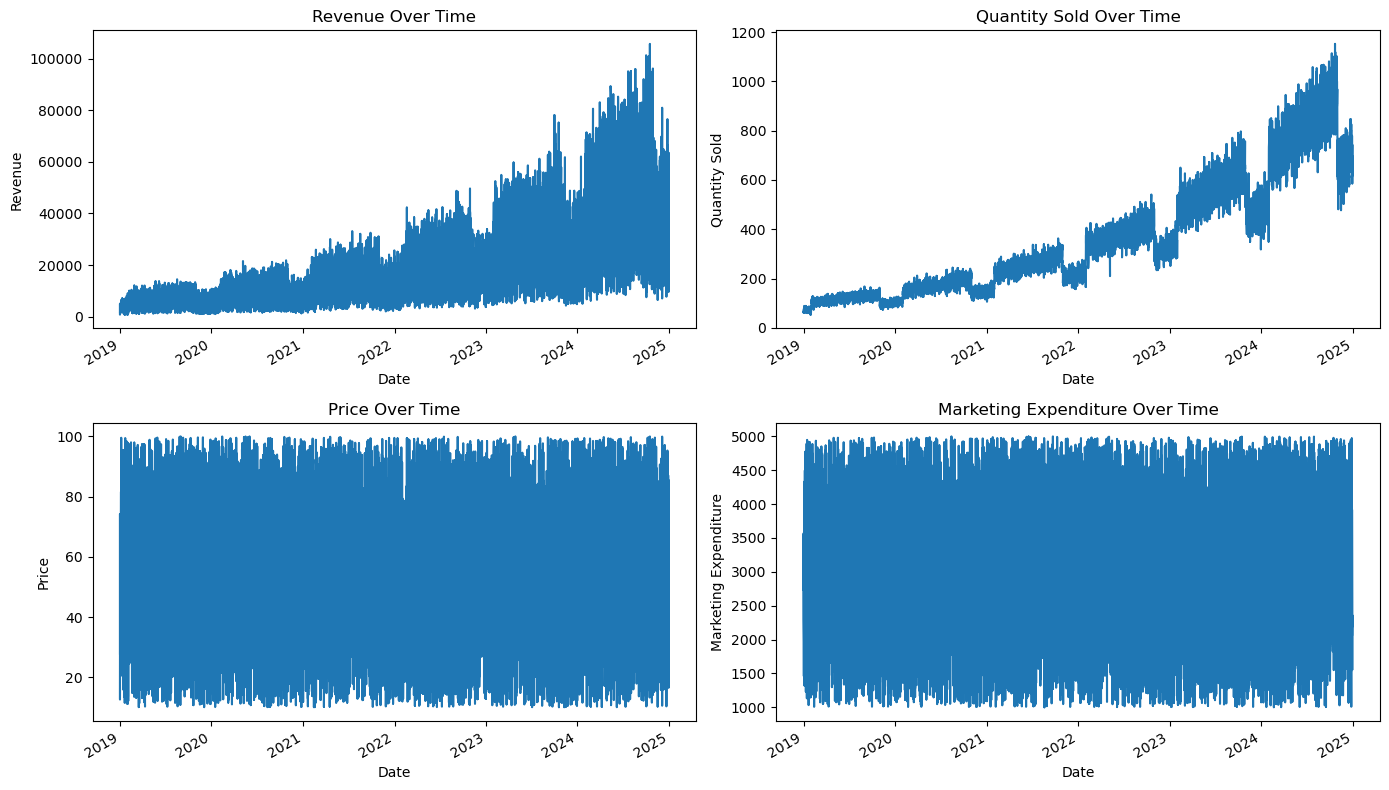

In [10]:
# Plotting some information
plt.figure(figsize=(14, 8))

# Plot Revenue over time
plt.subplot(2, 2, 1)
df['Revenue'].plot(title='Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')

# Plot Quantity Sold over time
plt.subplot(2, 2, 2)
df['Quantity_Sold'].plot(title='Quantity Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')

# Plot Price over time
plt.subplot(2, 2, 3)
df['Price'].plot(title='Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot Marketing Expenditure over time
plt.subplot(2, 2, 4)
df['Marketing_Expenditure'].plot(title='Marketing Expenditure Over Time')
plt.xlabel('Date')
plt.ylabel('Marketing Expenditure')

plt.tight_layout()
plt.show()

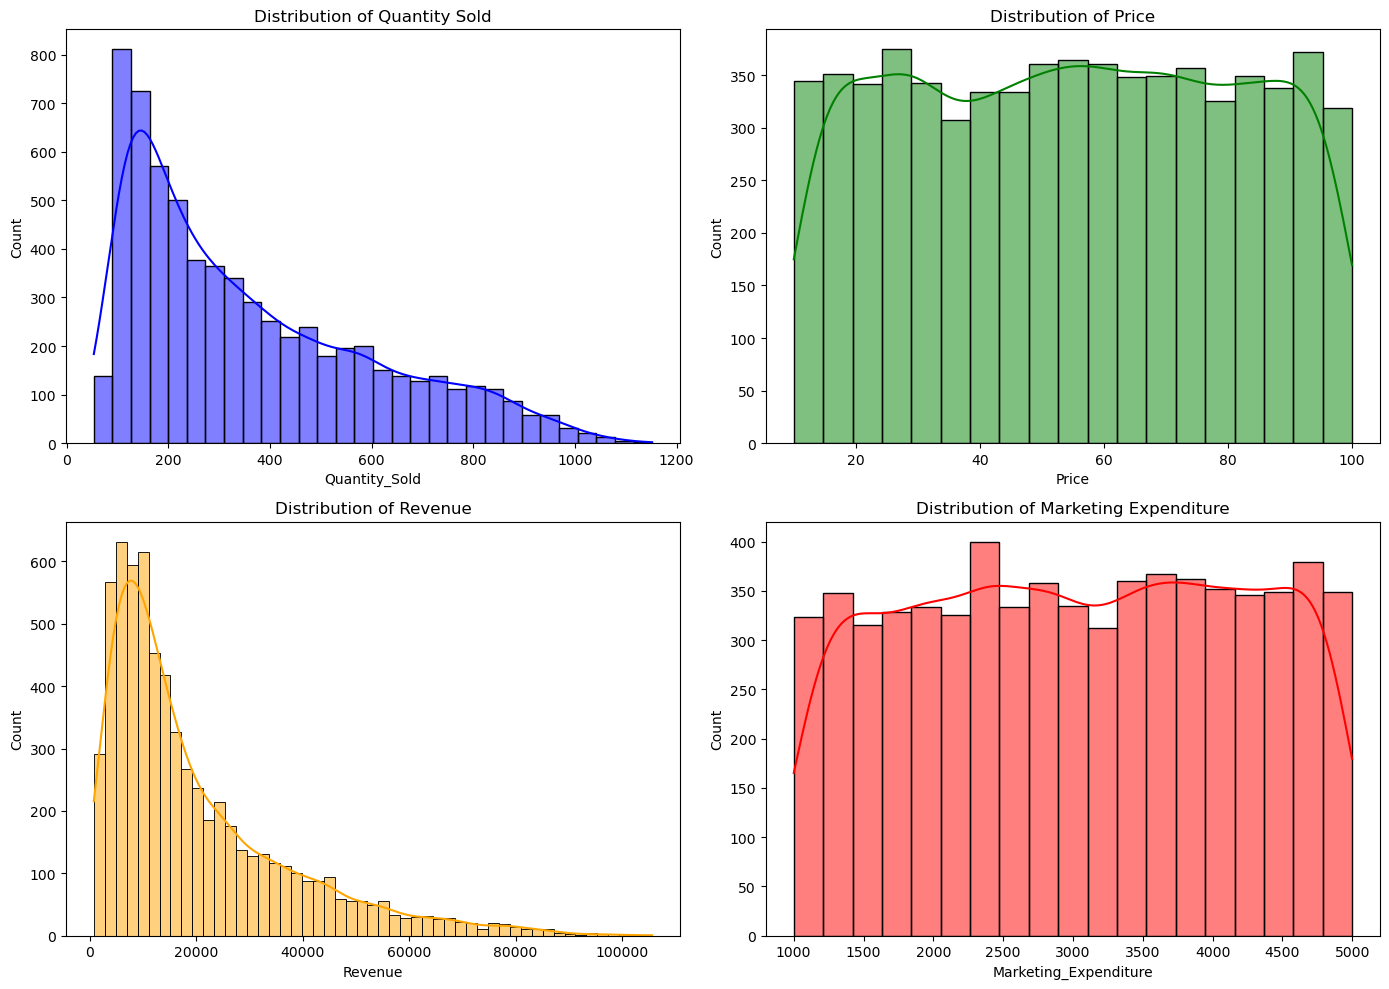

In [11]:
# Plot distributions of numerical columns
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['Quantity_Sold'], kde=True, color='blue')
plt.title('Distribution of Quantity Sold')

plt.subplot(2, 2, 2)
sns.histplot(df['Price'], kde=True, color='green')
plt.title('Distribution of Price')

plt.subplot(2, 2, 3)
sns.histplot(df['Revenue'], kde=True, color='orange')
plt.title('Distribution of Revenue')

plt.subplot(2, 2, 4)
sns.histplot(df['Marketing_Expenditure'], kde=True, color='red')
plt.title('Distribution of Marketing Expenditure')

plt.tight_layout()
plt.show()

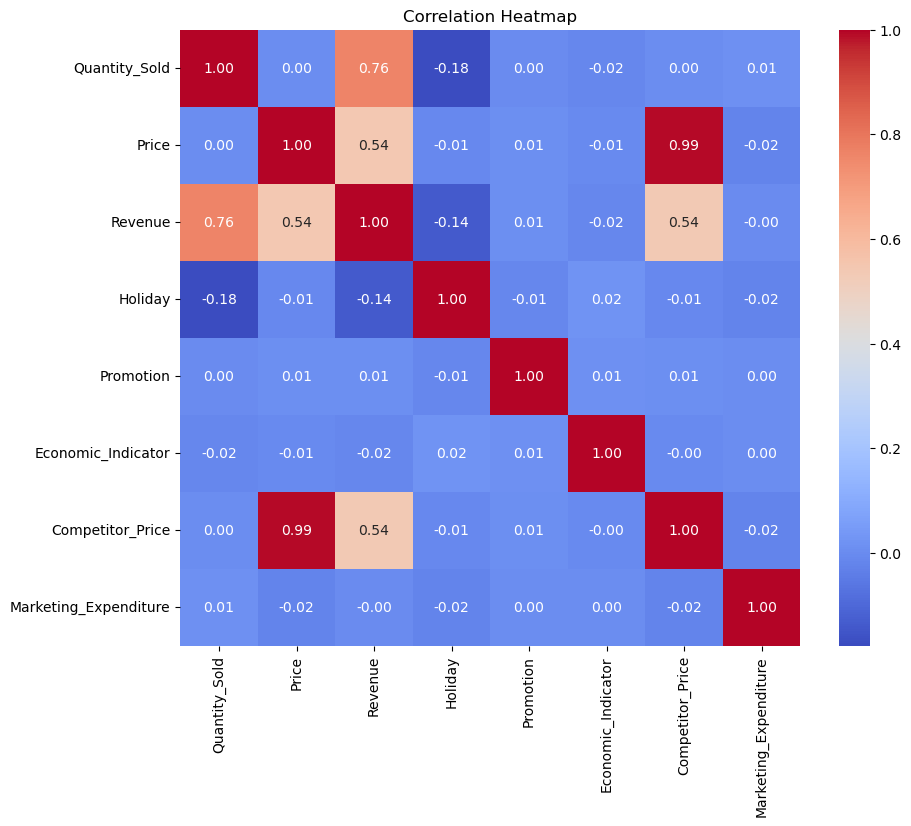

In [12]:
# Calculate correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

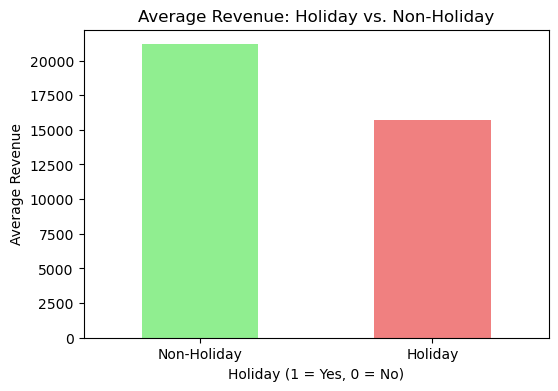

In [13]:
# Group by Holiday and calculate mean revenue
holiday_revenue = df.groupby('Holiday')['Revenue'].mean()

# Plot
plt.figure(figsize=(6, 4))
holiday_revenue.plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Average Revenue: Holiday vs. Non-Holiday')
plt.xlabel('Holiday (1 = Yes, 0 = No)')
plt.ylabel('Average Revenue')
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'], rotation=0)
plt.show()

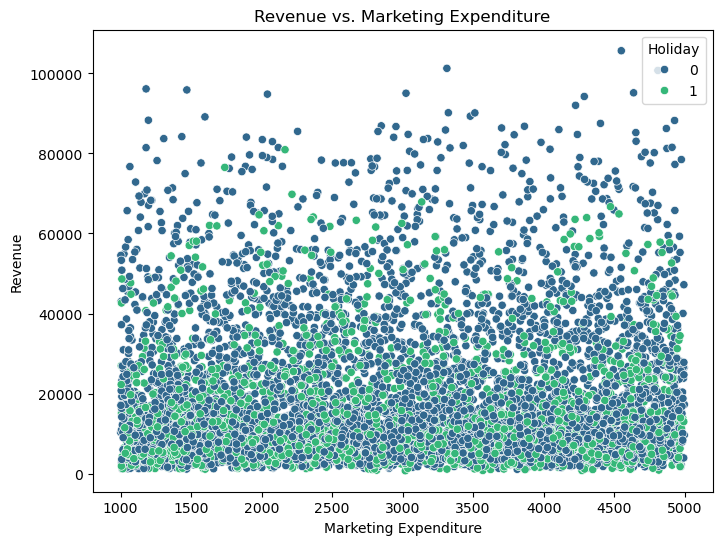

In [14]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Marketing_Expenditure'], y=df['Revenue'], hue=df['Holiday'], palette='viridis')
plt.title('Revenue vs. Marketing Expenditure')
plt.xlabel('Marketing Expenditure')
plt.ylabel('Revenue')
plt.show()

<Figure size 1500x1000 with 0 Axes>

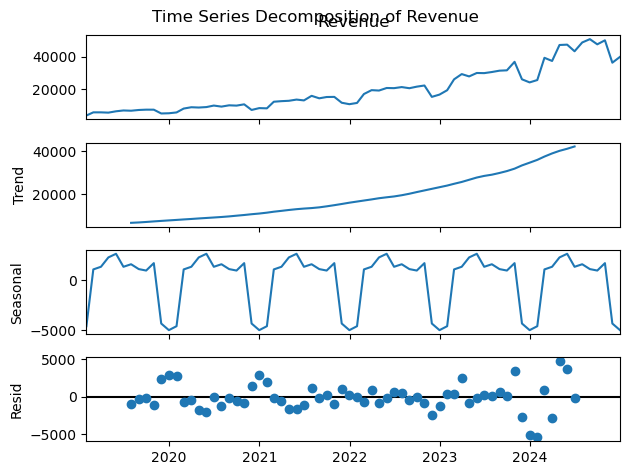

In [15]:
# Decompose Revenue time series
decomposition = seasonal_decompose(df['Revenue'].resample('M').mean(), model='additive', period=12)

# Plot decomposition
plt.figure(figsize=(15, 10))
decomposition.plot()
plt.suptitle('Time Series Decomposition of Revenue')
plt.show()

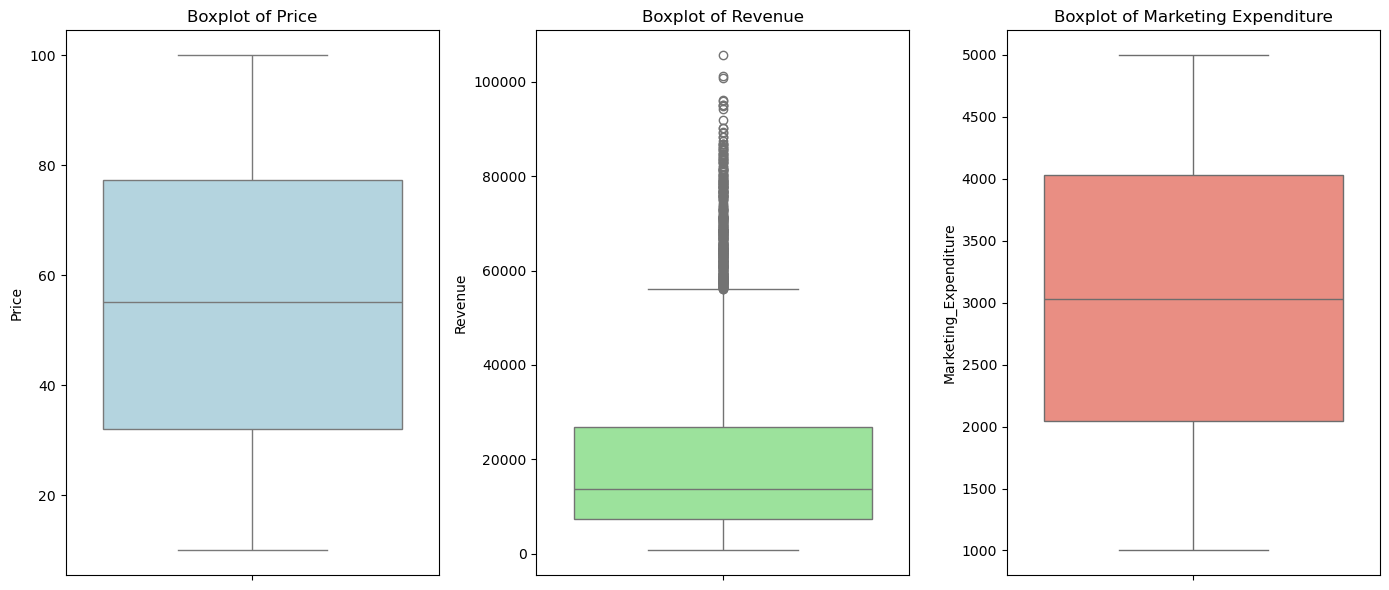

In [16]:
# Boxplots for numerical columns
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['Price'], color='lightblue')
plt.title('Boxplot of Price')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['Revenue'], color='lightgreen')
plt.title('Boxplot of Revenue')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['Marketing_Expenditure'], color='salmon')
plt.title('Boxplot of Marketing Expenditure')

plt.tight_layout()
plt.show()

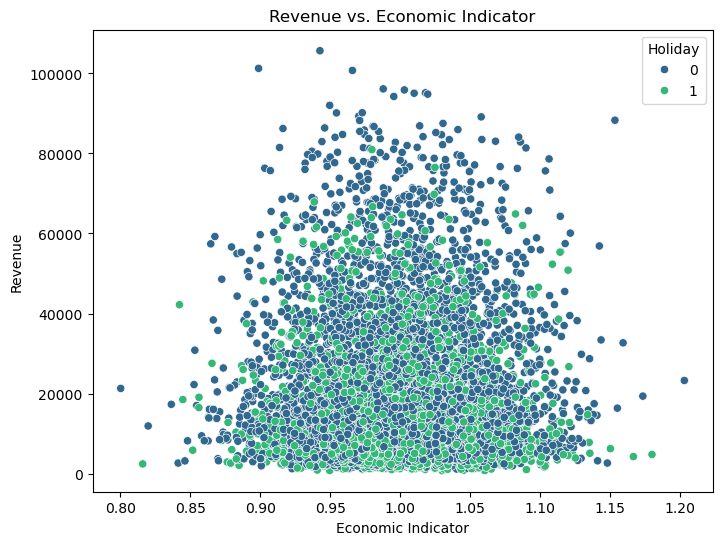

In [17]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Economic_Indicator'], y=df['Revenue'], hue=df['Holiday'], palette='viridis')
plt.title('Revenue vs. Economic Indicator')
plt.xlabel('Economic Indicator')
plt.ylabel('Revenue')
plt.show()

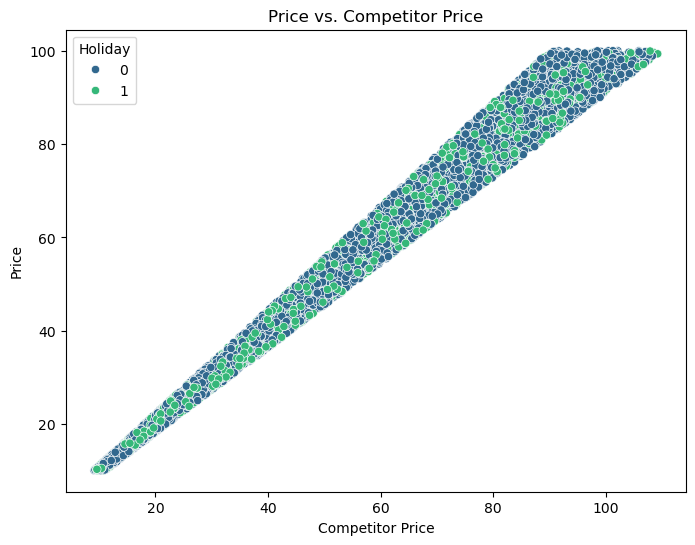

In [18]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Competitor_Price'], y=df['Price'], hue=df['Holiday'], palette='viridis')
plt.title('Price vs. Competitor Price')
plt.xlabel('Competitor Price')
plt.ylabel('Price')
plt.show()

In [19]:
weekly_df.head()

,Date,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure
0,2019-01-06,69.388889,50.962585,3469.202626,1.000000,0.166667,0.994566,50.994144,2685.601580
1,2019-01-13,74.047619,59.821806,4380.088800,1.000000,0.047619,0.998862,59.865522,3345.923932
2,2019-01-20,71.333333,55.039873,3859.773656,1.000000,0.047619,1.026844,56.069080,3075.631753
3,2019-01-27,73.047619,56.135005,4046.225333,1.000000,0.047619,1.000774,57.796635,3027.574115
4,2019-02-03,87.047619,55.959358,4790.388640,0.571429,0.142857,1.002826,56.901858,2718.206047


In [20]:
# Select features and target
features = weekly_df[['Price', 'Revenue', 'Holiday', 'Promotion', 'Economic_Indicator', 'Competitor_Price', 'Marketing_Expenditure']]
target = weekly_df['Quantity_Sold']

In [21]:
# Scale the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [22]:
# Create sequences
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

In [23]:
sequence_length = 12  # Use past 12 weeks to predict the next week
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

In [24]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [25]:
X_train.shape

(241, 12, 7)

In [26]:
X_test.shape

(61, 12, 7)

In [27]:
# Define the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense output layer
model.add(Dense(units=1))

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
8/8 [==============================] - 4s 52ms/step - loss: 0.0503 - val_loss: 0.1638
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - val_loss: 0.1946
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.0603
Epoch 4/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0348
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0242
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0403
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0158
Epoch 8/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0103
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0114
Epoch 10/50
8/8 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0155
Epoch 11/50
8/8 [=====================

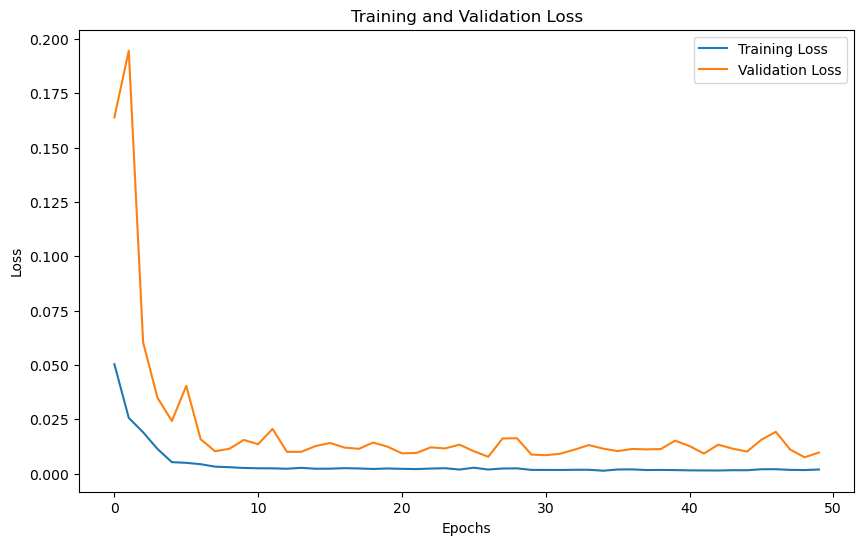

In [30]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 2ms/step
RMSE: 86.02621839701712


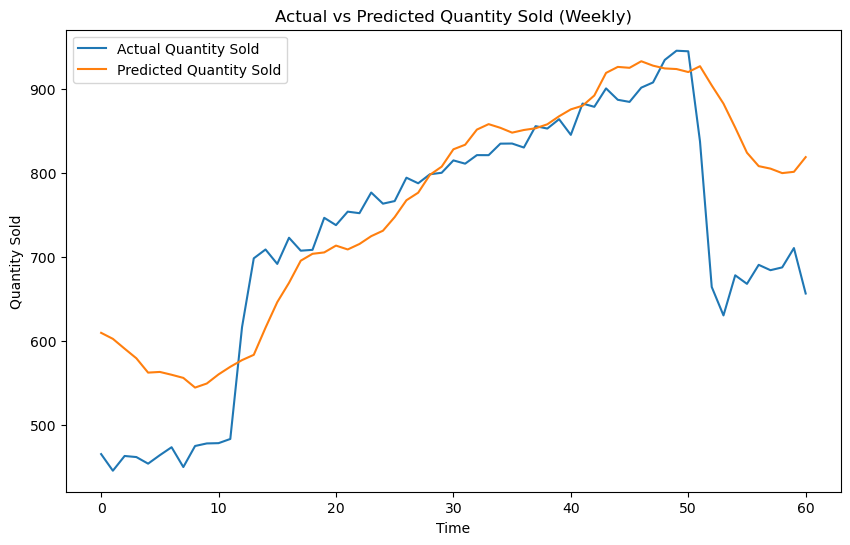

In [31]:
# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics (e.g., RMSE)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'RMSE: {rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Quantity Sold')
plt.plot(y_pred_actual, label='Predicted Quantity Sold')
plt.title('Actual vs Predicted Quantity Sold (Weekly)')
plt.xlabel('Time')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [32]:
# Define the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=1024, return_sequences=False))
model.add(Dropout(0.5))

# Add a Dense output layer
model.add(Dense(units=1))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 256)           270336    
                                                                 
 dropout_2 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 12, 512)           1574912   
                                                                 
 dropout_3 (Dropout)         (None, 12, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 1024)              6295552   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Train the model
history = model.fit(X, y, epochs=500, batch_size=32, validation_data=(X, y), verbose=1)

Epoch 1/500
10/10 [==============================] - 2s 79ms/step - loss: 0.0893 - val_loss: 0.0149
Epoch 2/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0223 - val_loss: 0.0140
Epoch 3/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 4/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 5/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 6/500
10/10 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 7/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 8/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 9/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/500
10/10 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 0.0026

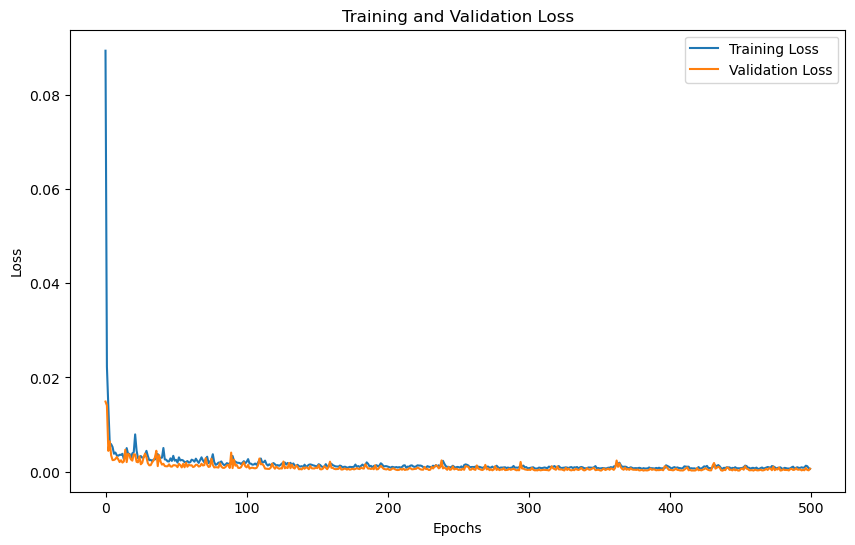

In [36]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

10/10 [==============================] - 0s 3ms/step
RMSE: 21.79932952829175


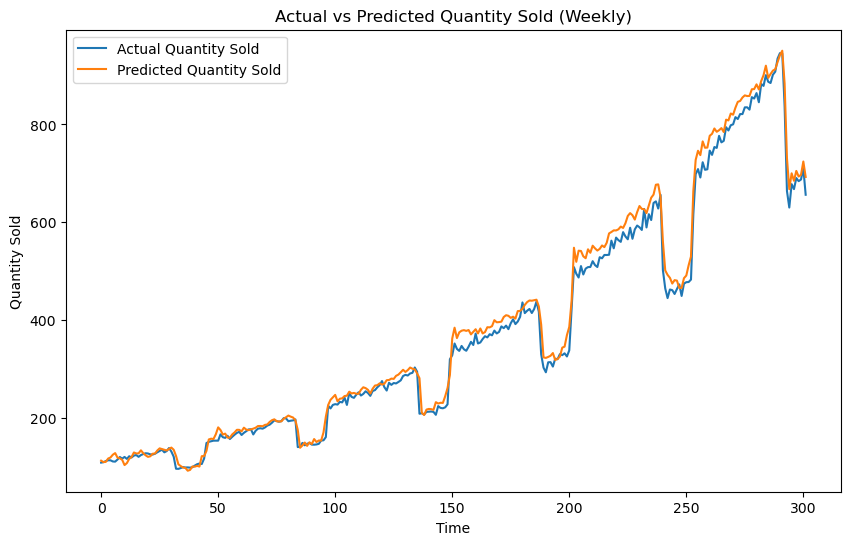

In [37]:
# Predict on the test data
y_pred = model.predict(X)

# Inverse transform the scaled predictions and actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate evaluation metrics (e.g., RMSE)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'RMSE: {rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Quantity Sold')
plt.plot(y_pred_actual, label='Predicted Quantity Sold')
plt.title('Actual vs Predicted Quantity Sold (Weekly)')
plt.xlabel('Time')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [38]:
# Function to forecast future values
def forecast_future(model, last_sequence, future_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence  # Start with the last sequence from the dataset

    for _ in range(future_steps):
        # Predict the next time step
        next_prediction = model.predict(current_sequence[np.newaxis, :, :])
        future_predictions.append(next_prediction[0, 0])

        # Update the sequence by removing the first time step and appending the prediction
        current_sequence = np.roll(current_sequence, shift=-1, axis=0)
        current_sequence[-1, -1] = next_prediction  # Update the last feature with the prediction

    # Inverse transform the predictions to the original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

In [39]:
# Get the last sequence from the dataset
last_sequence = X_test[-1]

# Number of future steps to predict (e.g., 52 weeks for the next year)
future_steps = 52

In [40]:
# Forecast future values
future_predictions = forecast_future(model, last_sequence, future_steps, scaler)

1/1 [==============================] - 0s 11ms/step


In [41]:
# Create a date range for the future predictions
last_date = weekly_df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=future_steps, freq='W')

In [42]:
# Create a DataFrame for the future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Quantity_Sold_Predicted': future_predictions.flatten()
})
future_df.set_index('Date', inplace=True)

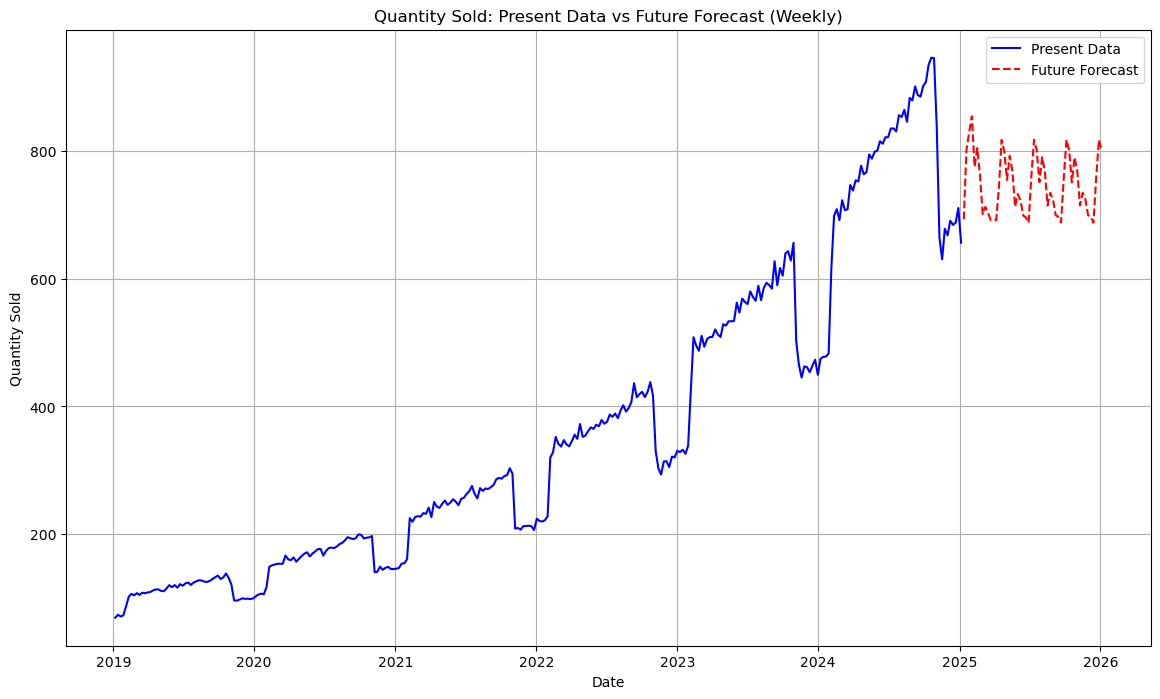

In [43]:
# Plot the present data and future forecasts
plt.figure(figsize=(14, 8))
plt.plot(weekly_df['Date'], weekly_df['Quantity_Sold'], label='Present Data', color='blue')
plt.plot(future_df.index, future_df['Quantity_Sold_Predicted'], label='Future Forecast', color='red', linestyle='--')
plt.title('Quantity Sold: Present Data vs Future Forecast (Weekly)')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid()
plt.show()

In [44]:
# Save the scaler to a file
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [45]:
model.save('sales_forcasting.h5')

In [ ]:
df = pd.read_csv(r"D:\Python project\forecasting\DATASET\DATA\sales_data_2019_2024.csv")
df.head()

,Date,Product_ID,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure
0,2019-01-01,P001,65,27.847453,1810.084413,1,0,0.979146,27.222685,2732.463151
1,2019-01-01,P002,67,74.206571,4971.840243,1,0,1.009036,79.857565,3049.973783
2,2019-01-01,P003,61,12.590628,768.028318,1,0,0.949585,12.540244,3569.035746
3,2019-01-02,P001,69,72.632744,5011.659370,1,0,0.993758,74.971921,1460.344758
4,2019-01-02,P002,77,28.767581,2215.103731,1,0,1.071022,31.621665,3547.491489


In [47]:
# Ensure 'Date' is a datetime column
df['Date'] = pd.to_datetime(df['Date'])

In [48]:
# Extract month and year from the date
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [49]:
# Group by Product, Year, and Month to calculate monthly sales
monthly_sales = df.groupby(['Product_ID', 'Year', 'Month'])[['Quantity_Sold', 'Price', 'Holiday']].sum().reset_index()

In [50]:
# Display the monthly sales data
monthly_sales.head()

,Product_ID,Year,Month,Quantity_Sold,Price,Holiday
0,P001,2019,1,2319,1765.957390,31
1,P001,2019,2,2928,1608.517275,0
2,P001,2019,3,3341,1743.540664,0
3,P001,2019,4,3385,1369.893237,0
4,P001,2019,5,3584,2187.076117,0


In [51]:
monthly_sales.tail()

,Product_ID,Year,Month,Quantity_Sold,Price,Holiday
211,P003,2024,8,25966,1783.495675,0
212,P003,2024,9,27044,1488.425158,0
213,P003,2024,10,29300,1589.574932,0
214,P003,2024,11,19893,1645.806352,30
215,P003,2024,12,21214,1590.176815,31


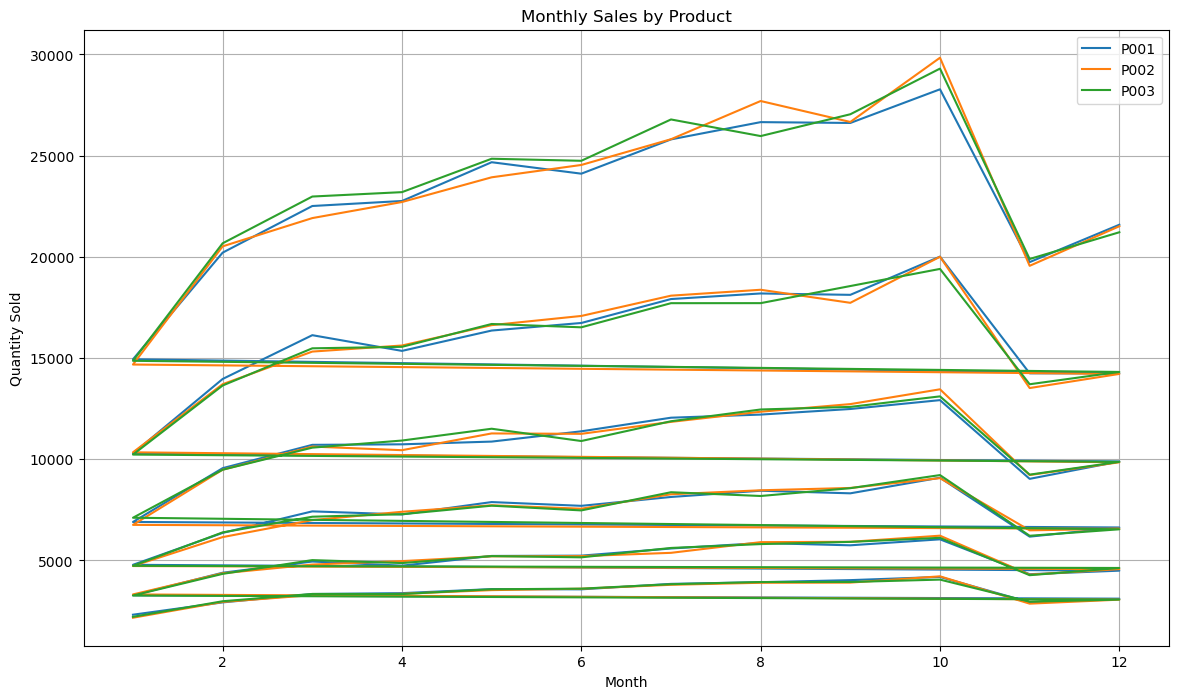

In [52]:
# Plot monthly sales for each product
plt.figure(figsize=(14, 8))
for product in ['P001', 'P002', 'P003']:
    product_data = monthly_sales[monthly_sales['Product_ID'] == product]
    plt.plot(product_data['Month'], product_data['Quantity_Sold'], label=product)

plt.title('Monthly Sales by Product')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid()
plt.show()

In [53]:
# Prepare features and target
features = monthly_sales[['Month', 'Year', 'Holiday', 'Price']]
target = monthly_sales['Quantity_Sold']

In [54]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [88]:
X_train.shape

(172, 4)

In [89]:
X_test.shape

(44, 4)

In [55]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

In [56]:
# Fit GridSearchCV to the training data
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [57]:
# Predict on the test data
y_pred = rf.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE with Best Model: {rmse}')

RMSE with Best Model: 437.02585566843436


In [58]:
# Create a DataFrame for future predictions (9th and 10th months)
future_data = pd.DataFrame({
    'Month': [9, 10],
    'Year': [2023, 2023],  # Replace with the appropriate year
    'Holiday': [1, 1],  # Example: Assume holidays in these months
    'Price': [30, 30]  # Example: Assume average price
})

In [59]:
# Predict demand for the 9th and 10th months
future_demand = rf.predict(future_data)
print(f'Predicted Demand for 9th and 10th Months: {future_demand}')

Predicted Demand for 9th and 10th Months: [18155.02 19550.79]


In [60]:
y_pred = rf.predict(features)

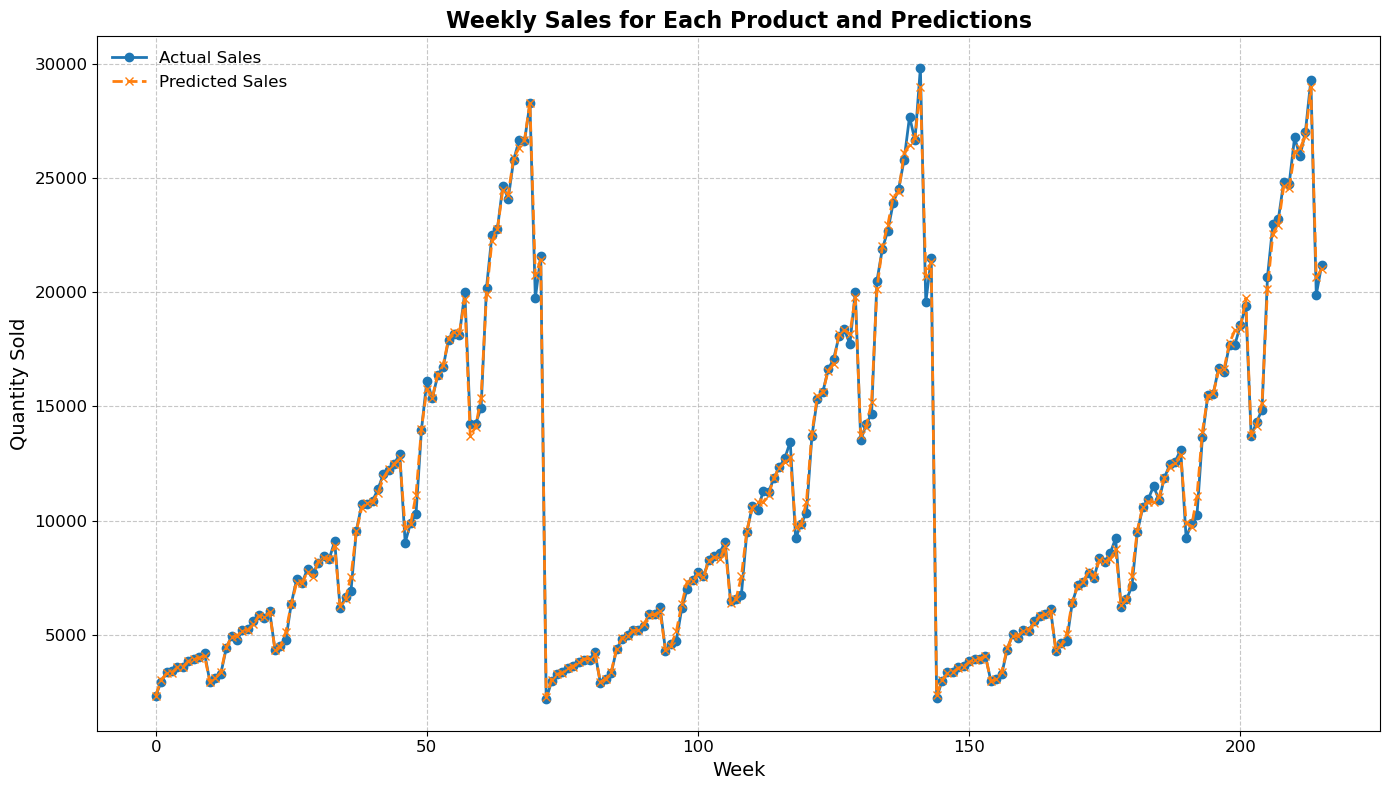

In [61]:
# Assuming 'target' and 'y_pred' represent the actual and predicted monthly sales
plt.figure(figsize=(14, 8))

# Plotting with customized line styles, colors, and labels
plt.plot(target, label='Actual Sales', color='tab:blue', linewidth=2, linestyle='-', marker='o')
plt.plot(y_pred, label='Predicted Sales', color='tab:orange', linewidth=2, linestyle='--', marker='x')

# Title and labels
plt.title('Weekly Sales for Each Product and Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Week', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)

# Adding a legend with a bit of transparency
plt.legend(fontsize=12, loc='upper left', frameon=False)

# Enabling gridlines and setting their style'
plt.grid(True, linestyle='--', alpha=0.7)

# Optional: Customize tick marks and labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # To ensure that labels are not cut off
plt.show()

In [62]:
# Save the model using pickle
with open('demand_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

In [63]:
df.head()

,Date,Product_ID,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure,Month,Year
0,2019-01-01,P001,65,27.847453,1810.084413,1,0,0.979146,27.222685,2732.463151,1,2019
1,2019-01-01,P002,67,74.206571,4971.840243,1,0,1.009036,79.857565,3049.973783,1,2019
2,2019-01-01,P003,61,12.590628,768.028318,1,0,0.949585,12.540244,3569.035746,1,2019
3,2019-01-02,P001,69,72.632744,5011.659370,1,0,0.993758,74.971921,1460.344758,1,2019
4,2019-01-02,P002,77,28.767581,2215.103731,1,0,1.071022,31.621665,3547.491489,1,2019


In [64]:
df['Week'] = df['Date'].dt.isocalendar().week

In [65]:
# Weekly Report (by Week)
weekly_report = df.groupby(['Year', 'Week']).agg({'Quantity_Sold': 'sum', 'Revenue': 'sum'}).reset_index()

In [66]:
# Monthly Report (by Month)
monthly_report = df.groupby(['Year', 'Month']).agg({'Quantity_Sold': 'sum', 'Revenue': 'sum'}).reset_index()

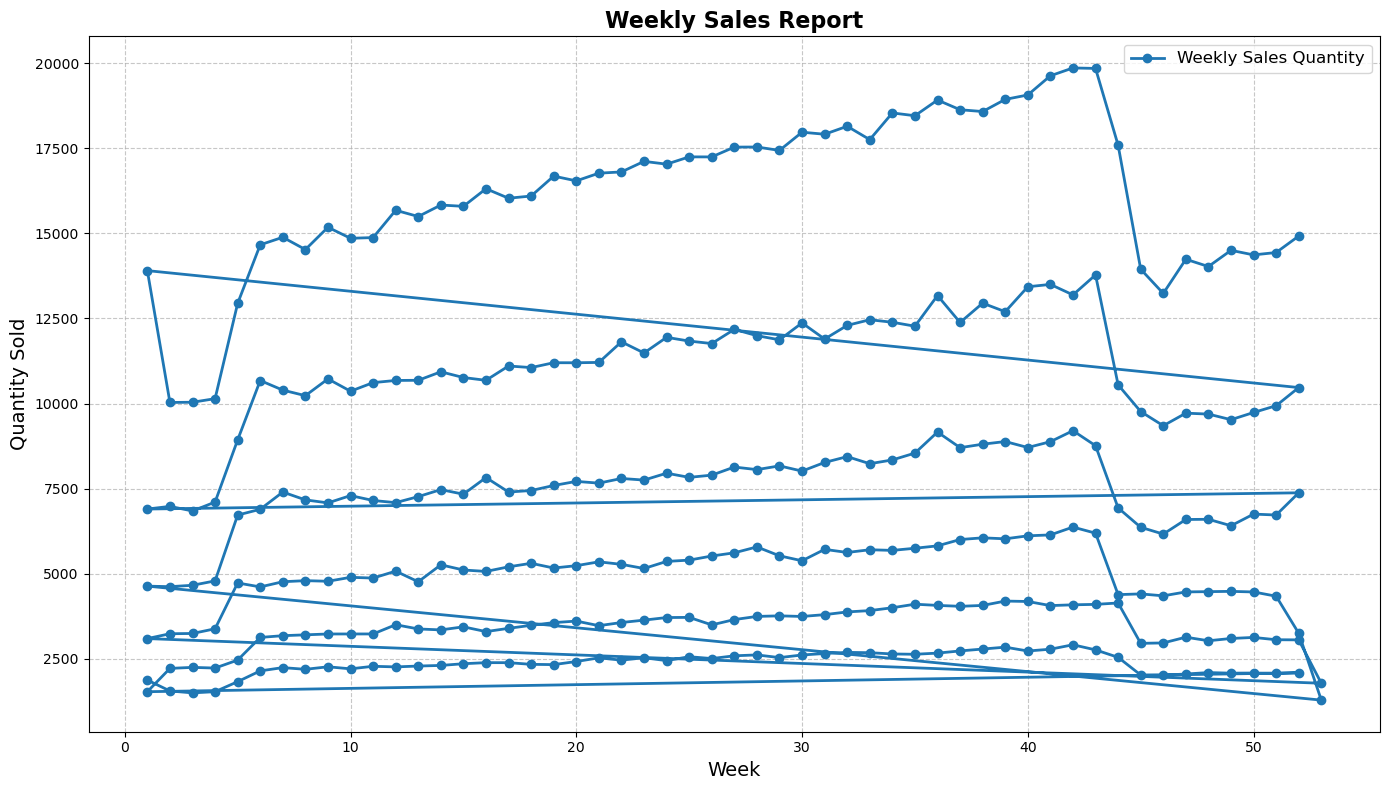

In [67]:
# Plotting weekly sales
plt.figure(figsize=(14, 8))
plt.plot(weekly_report['Week'], weekly_report['Quantity_Sold'], label='Weekly Sales Quantity', color='tab:blue', marker='o', linewidth=2)
plt.title('Weekly Sales Report', fontsize=16, fontweight='bold')
plt.xlabel('Week', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

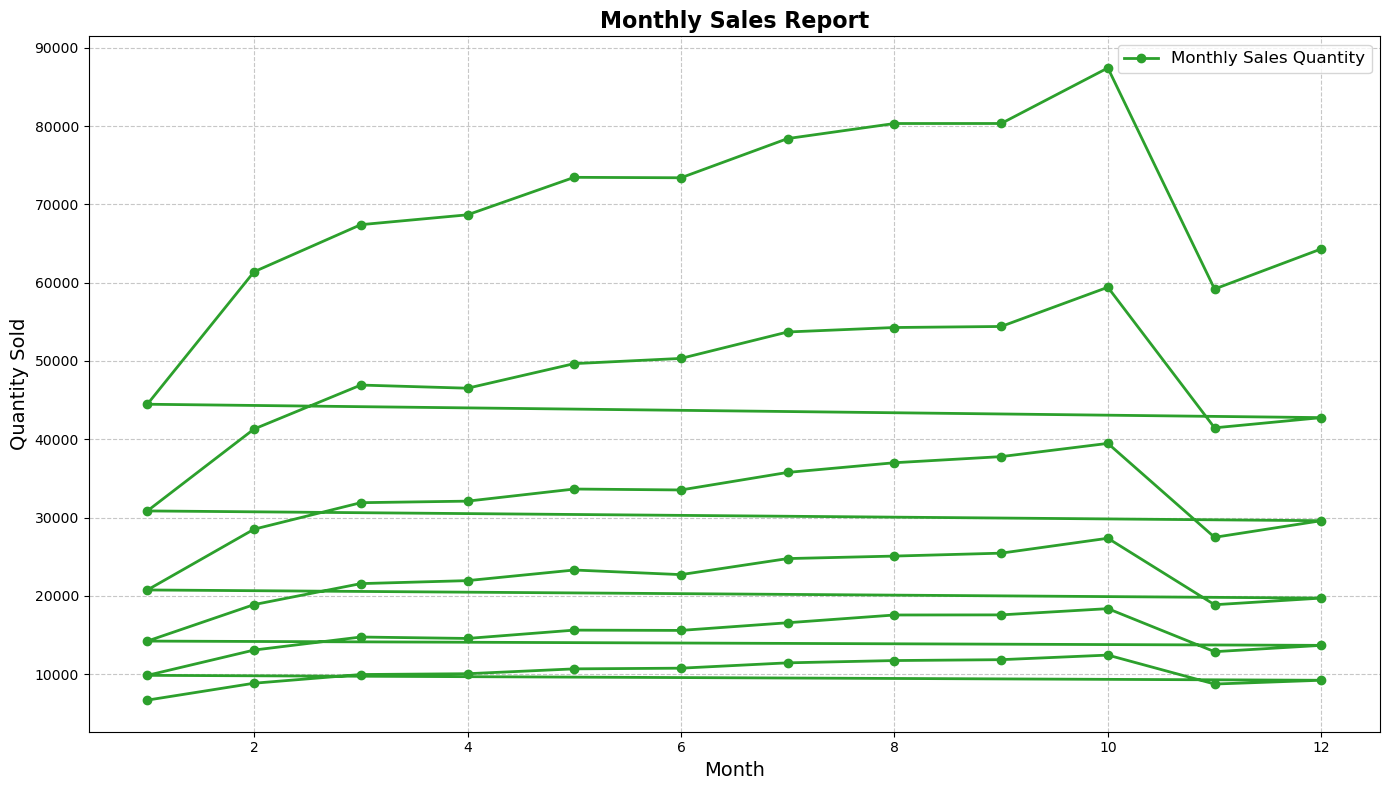

In [68]:
# Plotting monthly sales
plt.figure(figsize=(14, 8))
plt.plot(monthly_report['Month'], monthly_report['Quantity_Sold'], label='Monthly Sales Quantity', color='tab:green', marker='o', linewidth=2)
plt.title('Monthly Sales Report', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [69]:
df.head()

,Date,Product_ID,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure,Month,Year,Week
0,2019-01-01,P001,65,27.847453,1810.084413,1,0,0.979146,27.222685,2732.463151,1,2019,1
1,2019-01-01,P002,67,74.206571,4971.840243,1,0,1.009036,79.857565,3049.973783,1,2019,1
2,2019-01-01,P003,61,12.590628,768.028318,1,0,0.949585,12.540244,3569.035746,1,2019,1
3,2019-01-02,P001,69,72.632744,5011.659370,1,0,0.993758,74.971921,1460.344758,1,2019,1
4,2019-01-02,P002,77,28.767581,2215.103731,1,0,1.071022,31.621665,3547.491489,1,2019,1


In [70]:
df.tail(10)

,Date,Product_ID,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure,Month,Year,Week
6566,2024-12-28,P003,685,48.835860,33452.564235,1,0,0.994457,50.557633,1637.798486,12,2024,52
6567,2024-12-29,P001,689,34.064341,23470.331174,1,0,1.032198,35.006906,2341.036326,12,2024,52
6568,2024-12-29,P002,779,61.581270,47971.809362,1,0,1.027204,67.571667,2058.313370,12,2024,52
6569,2024-12-29,P003,612,71.491860,43753.018523,1,0,0.936781,69.756331,3916.746460,12,2024,52
6570,2024-12-30,P001,743,85.480256,63511.830480,1,0,1.034945,90.589038,2350.866756,12,2024,1
6571,2024-12-30,P002,586,16.598603,9726.781219,1,1,0.977679,17.260975,2316.695547,12,2024,1
6572,2024-12-30,P003,656,72.387461,47486.174594,1,0,1.021746,67.642677,2189.166443,12,2024,1
6573,2024-12-31,P001,696,78.348876,54530.817832,1,0,0.954823,74.629424,2355.234357,12,2024,1
6574,2024-12-31,P002,636,40.905358,26015.807583,1,0,0.962180,42.822685,1646.902804,12,2024,1
6575,2024-12-31,P003,621,24.040951,14929.430453,1,0,0.943845,23.450420,1564.579053,12,2024,1


In [71]:
df['Week'].unique()

<IntegerArray>
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Length: 53, dtype: UInt32

In [72]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date is in datetime format
df['Week'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year

In [73]:
weekly_sales = df.groupby(['Year', 'Week'])['Quantity_Sold'].sum().reset_index()
weekly_sales['Date'] = pd.to_datetime(weekly_sales['Year'].astype(str) + '-W' + weekly_sales['Week'].astype(str) + '-1', format='%Y-W%U-%w')

In [90]:
weekly_sales.shape

(314, 3)

In [74]:
# Set the 'Date' column as index
weekly_sales.set_index('Date', inplace=True)

In [75]:
# Fit SARIMA model (tune p, d, q, P, D, Q, S based on data analysis)
model = SARIMAX(weekly_sales['Quantity_Sold'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
weekly_results = model.fit()

c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [76]:
# Forecast the next 52 weeks
forecast = weekly_results.get_forecast(steps=52)
forecast_index = pd.date_range(start=weekly_sales.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W')
forecast_values = forecast.predicted_mean
forecast_df = pd.DataFrame({'Date': forecast_index, 'Forecast_Quantity_Sold': forecast_values})

c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


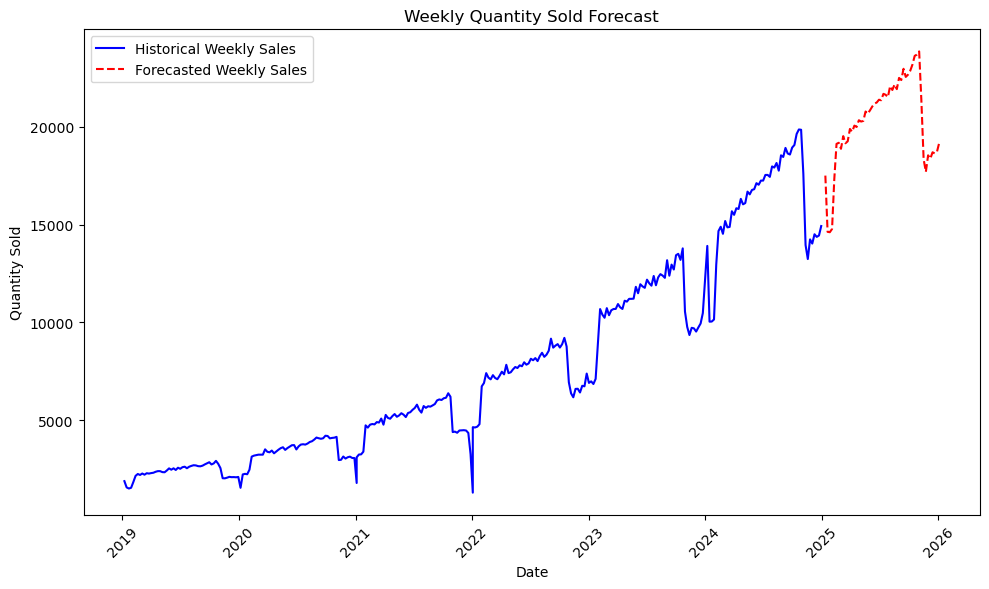

In [77]:
# Plot the historical weekly data
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales.index, weekly_sales['Quantity_Sold'], label='Historical Weekly Sales', color='blue')

# Plot the forecasted weekly sales
plt.plot(forecast_df['Date'], forecast_df['Forecast_Quantity_Sold'], label='Forecasted Weekly Sales', color='red', linestyle='--')

# Add titles and labels
plt.title('Weekly Quantity Sold Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [78]:
with open('sarimax_weekly_model.pkl', 'wb') as f:
    pickle.dump(weekly_results, f)

In [79]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [80]:
monthly_sales = df.groupby(['Year', 'Month'])['Quantity_Sold'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str) + '-01', format='%Y-%m-%d')

In [81]:
monthly_sales.set_index('Date', inplace=True)

In [91]:
monthly_sales.shape

(72, 3)

In [82]:
# Fit SARIMA model (tune p, d, q, P, D, Q, S based on data analysis)
model = SARIMAX(monthly_sales['Quantity_Sold'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
monthly_results = model.fit()

c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\Naveen\anaconda3\envs\tf_gpu\lib\site-packages

In [83]:
# Forecast the next 12 months
forecast = monthly_results.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
forecast_df_monthly = pd.DataFrame({'Date': forecast_index, 'Forecast_Quantity_Sold': forecast_values})

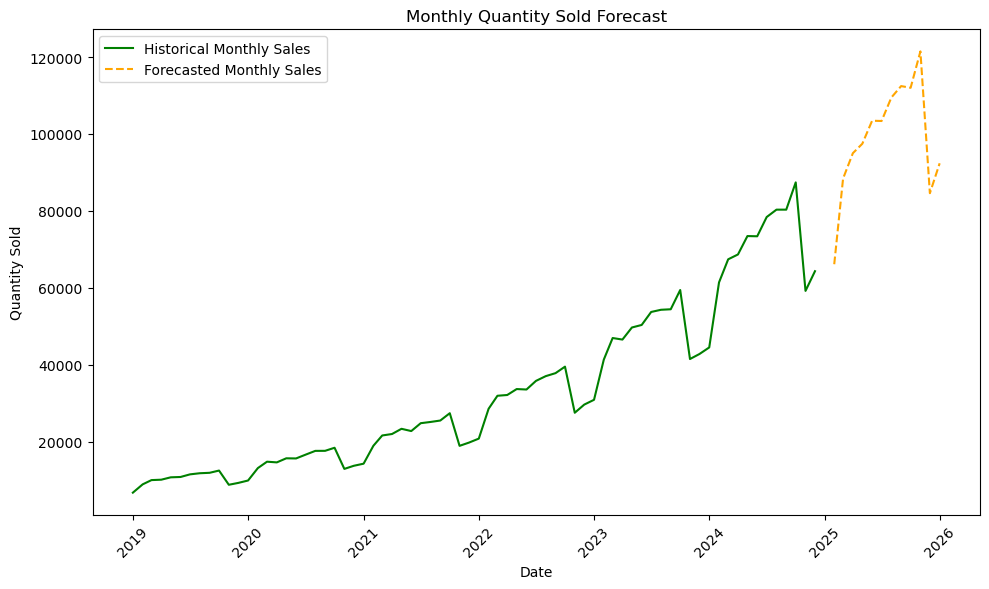

In [84]:
# Plot the historical monthly data
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales['Quantity_Sold'], label='Historical Monthly Sales', color='green')

# Plot the forecasted monthly sales
plt.plot(forecast_df_monthly['Date'], forecast_df_monthly['Forecast_Quantity_Sold'], label='Forecasted Monthly Sales', color='orange', linestyle='--')

# Add titles and labels
plt.title('Monthly Quantity Sold Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [85]:
# Save the fitted SARIMAX model to a pickle file
with open('sarimax_monthly_model.pkl', 'wb') as f:
    pickle.dump(monthly_results, f)

In [86]:
# Save the weekly forecast dataframe to CSV
df.to_csv('sales_forecast_processed.csv', index=False)

In [87]:
df.head()

,Date,Product_ID,Quantity_Sold,Price,Revenue,Holiday,Promotion,Economic_Indicator,Competitor_Price,Marketing_Expenditure,Month,Year,Week
0,2019-01-01,P001,65,27.847453,1810.084413,1,0,0.979146,27.222685,2732.463151,1,2019,1
1,2019-01-01,P002,67,74.206571,4971.840243,1,0,1.009036,79.857565,3049.973783,1,2019,1
2,2019-01-01,P003,61,12.590628,768.028318,1,0,0.949585,12.540244,3569.035746,1,2019,1
3,2019-01-02,P001,69,72.632744,5011.659370,1,0,0.993758,74.971921,1460.344758,1,2019,1
4,2019-01-02,P002,77,28.767581,2215.103731,1,0,1.071022,31.621665,3547.491489,1,2019,1
